In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.46:8787/status,
Dashboard: http://10.148.0.46:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.46:38879,Workers: 0
Dashboard: http://10.148.0.46:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## IMPORT DATA, build dataset

In [6]:
#CHOOSE INTERESTING DATA 
#_data_var = ['f','alti___distance','alti___time_difference','g_grad_x','denoised_g_grad_x', 'acc_x', 'acc_y', 'coriolis_x', 'coriolis_y']
_aviso_var = ['aviso_drifter_matchup_g_grad_x','aviso_drifter_matchup_g_grad_y']
_wind_var = ['es_drifter_matchup_tauu','es_drifter_matchup_tauv',
            'es_alti_matchup_tauu','es_alti_matchup_tauv']

list_wd_srce_suffix = ['es']
list_func = [stw.cst_rio_z15]
list_func_suffix = ['cstrio_z15']

DS={}
for l in labels : 
    #IMPORT DATA
    ds_wind = xr.open_zarr(zarr_dir+'/erastar_'+l+'.zarr')
    ds_wind = ds_wind.rename({v: 'es_'+v.replace("_es", "") for v in ds_wind if '_es'in v})
    ds_wind = ds_wind.rename({v: 'e5_'+v.replace("_e5", "") for v in ds_wind if '_e5'in v})
    ds_aviso = xr.open_zarr(zarr_dir+'/aviso_'+l+'.zarr')
    ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')
    ds_data = ds_data.rename({'g_grad_sla': 'g_grad_sla'.replace("sla", "x"), 'g_grad_sla_denoised': 'denoised_'+'g_grad_sla_denoised'.replace("sla_denoised", "x")})

    #DATASET FOR PDF
    ds = diag.datasets_for_pdfs(ds_data, ds_aviso, ds_wind, total_ds=True, except_ds=True,
                                _aviso_var = _aviso_var, _wind_var = _wind_var, 
                                list_wd_srce_suffix = list_wd_srce_suffix, list_func = list_func, list_func_suffix = list_func_suffix
                               )
    DS[l]=xr.merge(ds).persist()
    print(l)

gps_SASSA_SARAL_2018
gps_SASSA_Sentinel_2018
argos_SASSA_SARAL_2018
argos_SASSA_Sentinel_2018
argos_SASSA_Sentinel_2016
argos_PEACHI_Sentinel_2018
gps_PEACHI_Sentinel_2018


In [7]:
acc_bins=np.arange(-1e-4,1e-4,1e-6)
acc_bins1=np.arange(-5e-3,5e-3,1e-5)
dist_bins=np.arange(0,1e5,2e3)
time_bins=np.arange(0,1e4,2e2)
bins_list = {"acc": acc_bins, "alti___time_difference": time_bins}

ds_pdf = xr.concat([diag.compute_pdfs(DS[key][[var for var in DS[key] if var!='g_grad_x']], bins_list) for key in DS], dim=pd.Index(DS.keys(), name='drifter_sat_year'))
ds_pdf_grad = xr.concat([diag.compute_pdfs(DS[key][['g_grad_x']], bins_list) for key in DS],
                        dim=pd.Index(DS.keys(), name='drifter_sat_year')).rename_dims({'acc_bin':'acc_bin_grad'}).rename({'acc_bin':'acc_bin_grad'})
ds_pdf = xr.merge([ds_pdf, ds_pdf_grad])

In [8]:
ds_pdf_all = (ds_pdf.nb_coloc*ds_pdf[[v for v in ds_pdf if 'pdf' in v]]).sum('drifter_sat_year')/(ds_pdf.nb_coloc.sum('drifter_sat_year'))#normalized

list_sentinel = [l for l in ds_pdf.drifter_sat_year.values if 'SASSA_Sentinel' in l]
list_peachi = [l for l in ds_pdf.drifter_sat_year.values if 'PEACHI' in l]
list_saral = [l for l in ds_pdf.drifter_sat_year.values if 'SARAL' in l]
ds_pdf_sentinel = (ds_pdf.nb_coloc*ds_pdf[[v for v in ds_pdf if 'pdf' in v]]).sel(drifter_sat_year = list_sentinel).sum('drifter_sat_year')/(ds_pdf.sel(drifter_sat_year = list_sentinel).nb_coloc.sum('drifter_sat_year'))
ds_pdf_peachi = (ds_pdf.nb_coloc*ds_pdf[[v for v in ds_pdf if 'pdf' in v]]).sel(drifter_sat_year = list_peachi).sum('drifter_sat_year')/(ds_pdf.sel(drifter_sat_year = list_peachi).nb_coloc.sum('drifter_sat_year'))
ds_pdf_saral = (ds_pdf.nb_coloc*ds_pdf[[v for v in ds_pdf if 'pdf' in v]]).sel(drifter_sat_year = list_saral).sum('drifter_sat_year')/(ds_pdf.sel(drifter_sat_year = list_saral).nb_coloc.sum('drifter_sat_year'))

list_argos = [l for l in ds_pdf.drifter_sat_year.values if 'argos' in l]
list_gps = [l for l in ds_pdf.drifter_sat_year.values if 'gps' in l]
ds_pdf_argos = (ds_pdf.nb_coloc*ds_pdf[[v for v in ds_pdf if 'pdf' in v]]).sel(drifter_sat_year = list_argos).sum('drifter_sat_year')/(ds_pdf.sel(drifter_sat_year = list_argos).nb_coloc.sum('drifter_sat_year'))
ds_pdf_gps = (ds_pdf.nb_coloc*ds_pdf[[v for v in ds_pdf if 'pdf' in v]]).sel(drifter_sat_year = list_gps).sum('drifter_sat_year')/(ds_pdf.sel(drifter_sat_year = list_gps).nb_coloc.sum('drifter_sat_year'))

In [9]:
ds_std_all = diag.ds_mean_var_std_2bins(ds_pdf_all,'acc_bin', 'acc_bin_grad')
ds_std_argos = diag.ds_mean_var_std_2bins(ds_pdf_argos,'acc_bin', 'acc_bin_grad')
ds_std_gps = diag.ds_mean_var_std_2bins(ds_pdf_gps,'acc_bin', 'acc_bin_grad')

In [10]:
ds_var_all = diag.ds_mean_var_std_2bins(ds_pdf_all,'acc_bin','acc_bin_grad', var=True, std=False)
ds_var_argos = diag.ds_mean_var_std_2bins(ds_pdf_argos, 'acc_bin', 'acc_bin_grad', var=True, std=False)
ds_var_gps = diag.ds_mean_var_std_2bins(ds_pdf_gps, 'acc_bin', 'acc_bin_grad', var=True, std=False)

## On all data
### STD

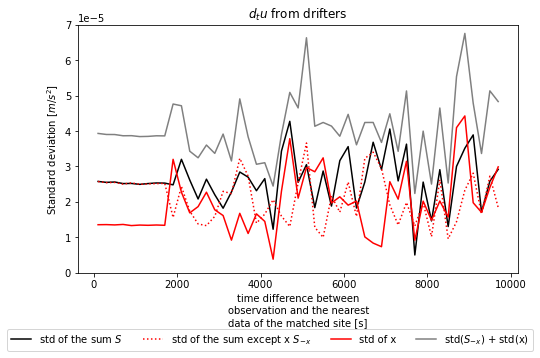

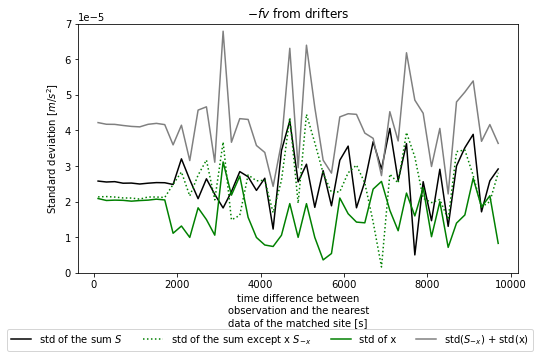

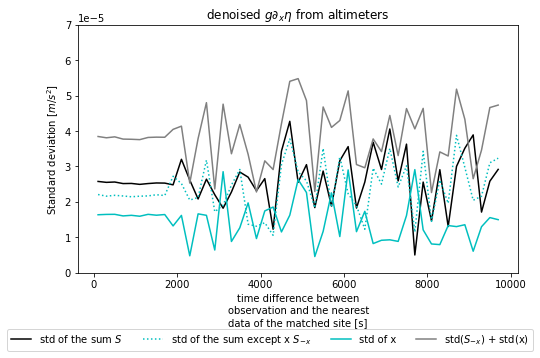

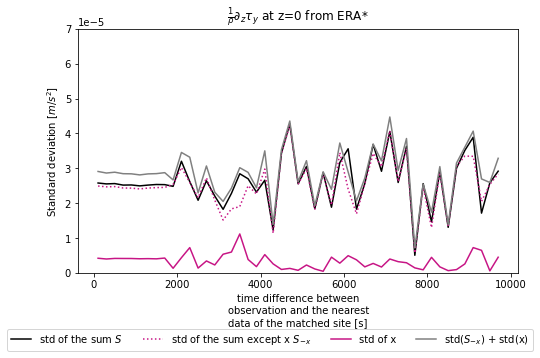

In [11]:
key = ['acc', 'coriolis', 'ggrad','wind']
name = ['acc', 'coriolis', 'denoised_g_grad','es_cstrio_z15_drifter_wd']
colors = ['r', 'g', 'c', 'mediumvioletred']
id_ = '_co_denoised_es_cstrio_z15_drifter_x'
title = [r'$d_tu$ from drifters',
          r'$-fv$ from drifters',
          r"denoised $g\partial_x\eta$ from altimeters",
          r'$\frac{1}{\rho}\partial_z\tau_y$ at z=0 from ERA*']
labels_ = [r'std of the sum $S$', 
           'std of the sum except x $S_{-x}$',
           'std of x',
           r'std($S_{-x}$) + std(x)']

for i in range(len(key)) :
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1,1,1)
    ds_std_all['std_sum'+id_].plot(color = 'k', ax=ax, label=labels_[0])
    ds_std_all['std_exc_'+key[i]+id_].plot(color = colors[i], ls=':', ax=ax, label=labels_[1])
    ds_std_all['std_'+name[i]+'_x'].plot(color = colors[i], ax=ax, label=labels_[2])
    (ds_std_all['std_'+name[i]+'_x']+ds_std_all['std_exc_'+key[i]+id_]).plot(color ='grey', ax=ax, label=labels_[3])
    ax.set_ylim(0,7e-5)
    ax.set_ylabel(r'Standard deviation [$m/s^2$]')
    ax.set_title(title[i])
    #fig.suptitle('Closure dependance to the time difference between the drifter \n and the altimeter at machtup time ')
    fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=4, fontsize=10)#bbox_transform=fig.transFigure,
    fig.tight_layout(rect=[0,0.05,1,1])#left, bottom, right, top (default is 0,0,1,1)

### Variance

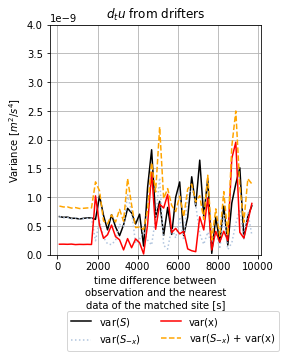

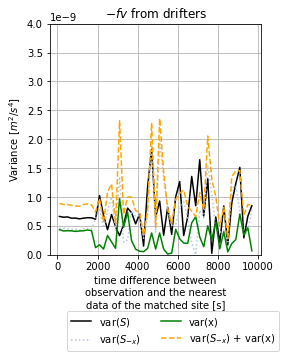

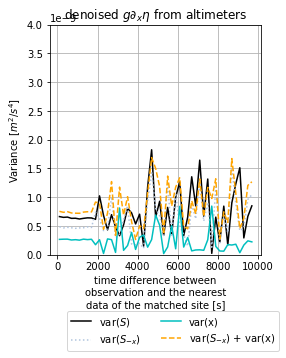

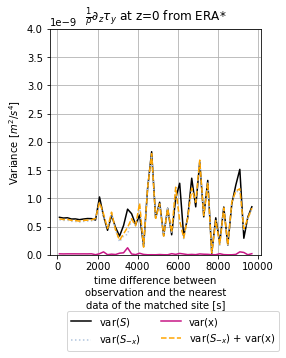

In [12]:
key = ['acc', 'coriolis', 'ggrad','wind']
name = ['acc', 'coriolis', 'denoised_g_grad','es_cstrio_z15_drifter_wd']
colors = ['r', 'g', 'c', 'mediumvioletred']
id_ = '_co_denoised_es_cstrio_z15_drifter_x'
title = [r'$d_tu$ from drifters',
          r'$-fv$ from drifters',
          r"denoised $g\partial_x\eta$ from altimeters",
          r'$\frac{1}{\rho}\partial_z\tau_y$ at z=0 from ERA*']
labels_ = [r'var($S$)', 
           'var($S_{-x}$)',
           'var(x)',
           r'var($S_{-x}$) + var(x)']

for i in range(len(key)) :
    fig = plt.figure(figsize=(4,5))
    ax = fig.add_subplot(1,1,1)
    ds_var_all['var_sum'+id_].plot(color = 'k', ax=ax, label=labels_[0])
    ds_var_all['var_exc_'+key[i]+id_].plot(color = 'lightsteelblue', ls=':', ax=ax, label=labels_[1])
    ds_var_all['var_'+name[i]+'_x'].plot(color = colors[i], ax=ax, label=labels_[2])
    (ds_var_all['var_'+name[i]+'_x']+ds_var_all['var_exc_'+key[i]+id_]).plot(color ='orange', ls='--', ax=ax, label=labels_[3])
    ax.grid()
    ax.set_ylim(0,4e-9)
    ax.set_ylabel(r'Variance [$m^2/s^4$]')
    ax.set_title(title[i])
    #fig.suptitle('Closure dependance to the time difference between the drifter \n and the altimeter at machtup time ')
    fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=2, fontsize=10)#bbox_transform=fig.transFigure,
    fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

## For GPS only
### STD

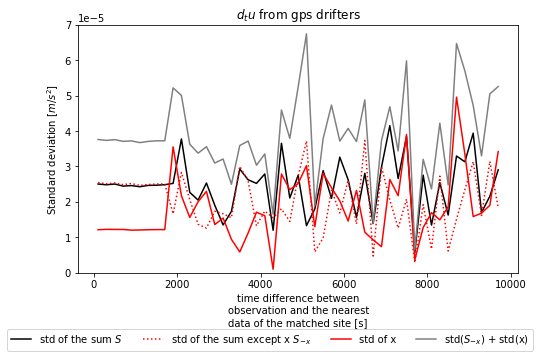

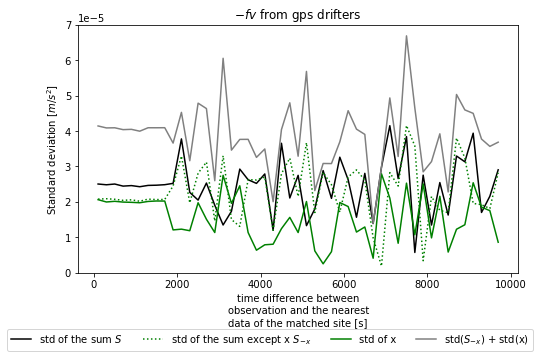

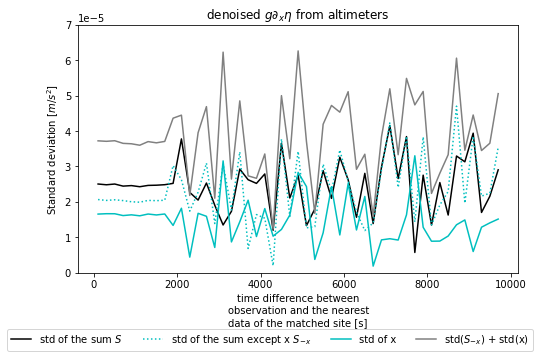

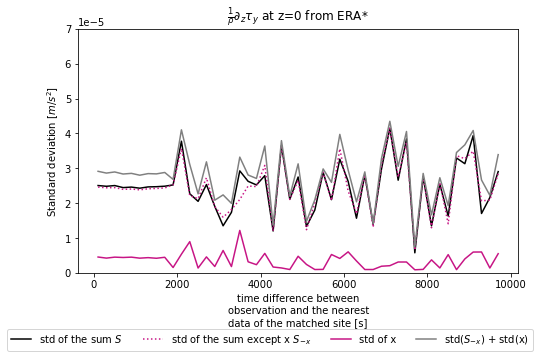

In [10]:
key = ['acc', 'coriolis', 'ggrad','wind']
name = ['acc', 'coriolis', 'denoised_g_grad','es_cstrio_z15_drifter_wd']
colors = ['r', 'g', 'c', 'mediumvioletred']
id_ = '_co_denoised_es_cstrio_z15_drifter_x'
title = [r'$d_tu$ from gps drifters',
          r'$-fv$ from gps drifters',
          r"denoised $g\partial_x\eta$ from altimeters",
          r'$\frac{1}{\rho}\partial_z\tau_y$ at z=0 from ERA*']
labels_ = [r'std of the sum $S$', 
           'std of the sum except x $S_{-x}$',
           'std of x',
           r'std($S_{-x}$) + std(x)']

for i in range(len(key)) :
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1,1,1)
    ds_std_gps['std_sum'+id_].plot(color = 'k', ax=ax, label=labels_[0])
    ds_std_gps['std_exc_'+key[i]+id_].plot(color = colors[i], ls=':', ax=ax, label=labels_[1])
    ds_std_gps['std_'+name[i]+'_x'].plot(color = colors[i], ax=ax, label=labels_[2])
    (ds_std_gps['std_'+name[i]+'_x']+ds_std_gps['std_exc_'+key[i]+id_]).plot(color ='grey', ax=ax, label=labels_[3])
    ax.set_ylim(0,7e-5)
    ax.set_ylabel(r'Standard deviation [$m/s^2$]')
    ax.set_title(title[i])
    #fig.suptitle('Closure dependance to the time difference between the drifter \n and the altimeter at machtup time ')
    fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=4, fontsize=10)#bbox_transform=fig.transFigure,
    fig.tight_layout(rect=[0,0.05,1,1])#left, bottom, right, top (default is 0,0,1,1)

### Variance

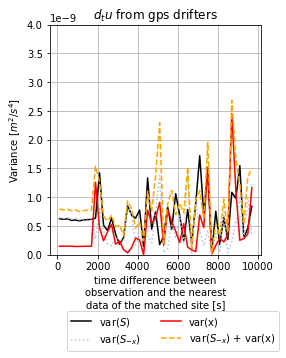

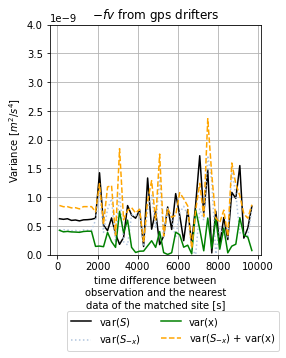

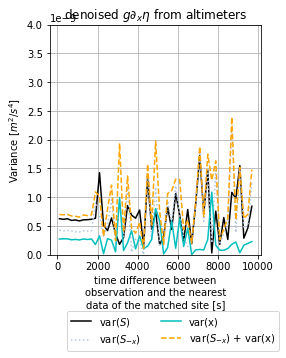

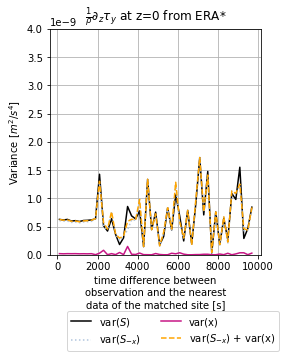

In [11]:
key = ['acc', 'coriolis', 'ggrad','wind']
name = ['acc', 'coriolis', 'denoised_g_grad','es_cstrio_z15_drifter_wd']
colors = ['r', 'g', 'c', 'mediumvioletred']
id_ = '_co_denoised_es_cstrio_z15_drifter_x'
title = [r'$d_tu$ from gps drifters',
          r'$-fv$ from gps drifters',
          r"denoised $g\partial_x\eta$ from altimeters",
          r'$\frac{1}{\rho}\partial_z\tau_y$ at z=0 from ERA*']
labels_ = [r'var($S$)', 
           'var($S_{-x}$)',
           'var(x)',
           r'var($S_{-x}$) + var(x)']

for i in range(len(key)) :
    fig = plt.figure(figsize=(4,5))
    ax = fig.add_subplot(1,1,1)
    ds_var_gps['var_sum'+id_].plot(color = 'k', ax=ax, label=labels_[0])
    ds_var_gps['var_exc_'+key[i]+id_].plot(color = 'lightsteelblue', ls=':', ax=ax, label=labels_[1])
    ds_var_gps['var_'+name[i]+'_x'].plot(color = colors[i], ax=ax, label=labels_[2])
    (ds_var_gps['var_'+name[i]+'_x']+ds_var_gps['var_exc_'+key[i]+id_]).plot(color ='orange',ls='--', ax=ax, label=labels_[3])
    ax.set_ylim(0,4e-9)
    ax.set_ylabel(r'Variance [$m^2/s^4$]')
    ax.set_title(title[i])
    ax.grid()
    #fig.suptitle('Closure dependance to the time difference between the drifter \n and the altimeter at machtup time ')
    fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=2, fontsize=10)#bbox_transform=fig.transFigure,
    fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

## For argos only

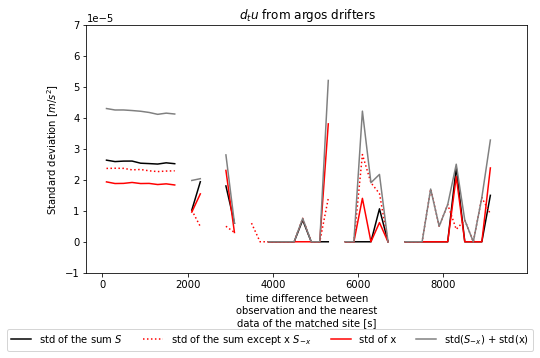

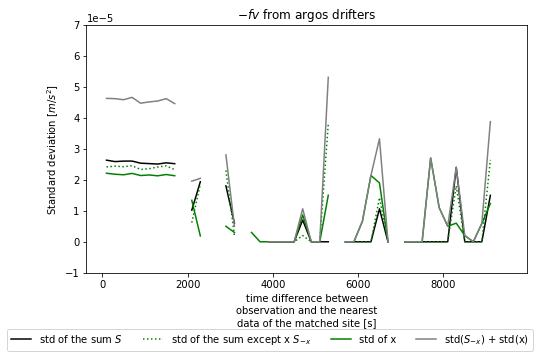

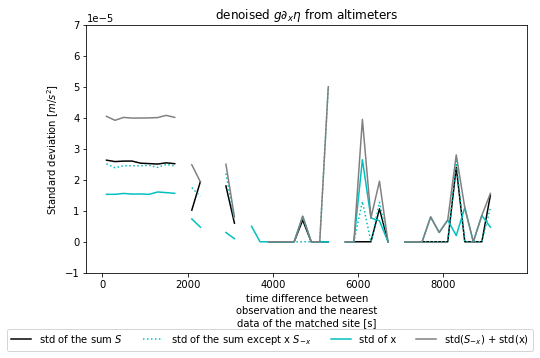

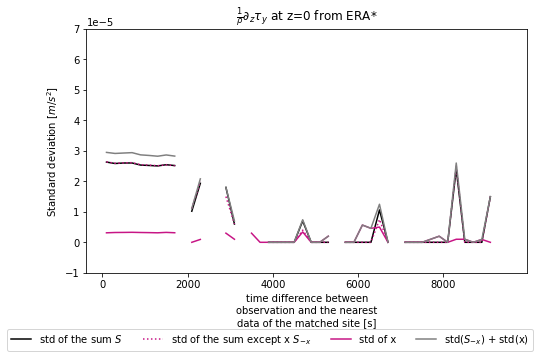

In [12]:
key = ['acc', 'coriolis', 'ggrad','wind']
name = ['acc', 'coriolis', 'denoised_g_grad','es_cstrio_z15_drifter_wd']
colors = ['r', 'g', 'c', 'mediumvioletred']
id_ = '_co_denoised_es_cstrio_z15_drifter_x'
title = [r'$d_tu$ from argos drifters',
          r'$-fv$ from argos drifters',
          r"denoised $g\partial_x\eta$ from altimeters",
          r'$\frac{1}{\rho}\partial_z\tau_y$ at z=0 from ERA*']
labels_ = [r'std of the sum $S$', 
           'std of the sum except x $S_{-x}$',
           'std of x',
           r'std($S_{-x}$) + std(x)']

for i in range(len(key)) :
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1,1,1)
    ds_std_argos['std_sum'+id_].plot(color = 'k', ax=ax, label=labels_[0])
    ds_std_argos['std_exc_'+key[i]+id_].plot(color = colors[i], ls=':', ax=ax, label=labels_[1])
    ds_std_argos['std_'+name[i]+'_x'].plot(color = colors[i], ax=ax, label=labels_[2])
    (ds_std_argos['std_'+name[i]+'_x']+ds_std_argos['std_exc_'+key[i]+id_]).plot(color ='grey', ax=ax, label=labels_[3])
    ax.set_ylim(-1e-5,7e-5)
    ax.set_ylabel(r'Standard deviation [$m/s^2$]')
    ax.set_title(title[i])
    #fig.suptitle('Closure dependance to the time difference between the drifter \n and the altimeter at machtup time ')
    fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=4, fontsize=10)#bbox_transform=fig.transFigure,
    fig.tight_layout(rect=[0,0.05,1,1])#left, bottom, right, top (default is 0,0,1,1)

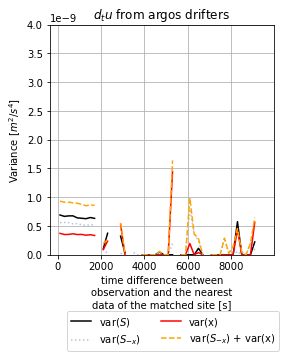

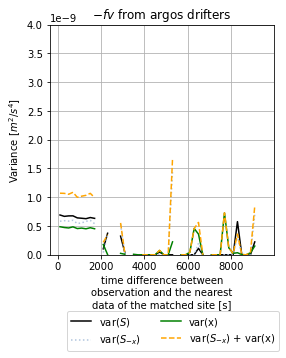

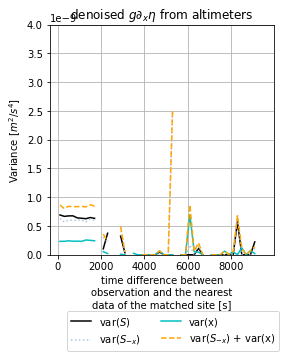

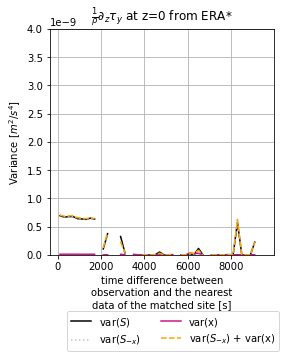

In [13]:
key = ['acc', 'coriolis', 'ggrad','wind']
name = ['acc', 'coriolis', 'denoised_g_grad','es_cstrio_z15_drifter_wd']
colors = ['r', 'g', 'c', 'mediumvioletred']
id_ = '_co_denoised_es_cstrio_z15_drifter_x'
title = [r'$d_tu$ from argos drifters',
          r'$-fv$ from argos drifters',
          r"denoised $g\partial_x\eta$ from altimeters",
          r'$\frac{1}{\rho}\partial_z\tau_y$ at z=0 from ERA*']
labels_ = [r'var($S$)', 
           'var($S_{-x}$)',
           'var(x)',
           r'var($S_{-x}$) + var(x)']

for i in range(len(key)) :
    fig = plt.figure(figsize=(4,5))
    ax = fig.add_subplot(1,1,1)
    ds_var_argos['var_sum'+id_].plot(color = 'k', ax=ax, label=labels_[0])
    ds_var_argos['var_exc_'+key[i]+id_].plot(color = 'lightsteelblue', ls=':', ax=ax, label=labels_[1])
    ds_var_argos['var_'+name[i]+'_x'].plot(color = colors[i], ax=ax, label=labels_[2])
    (ds_var_argos['var_'+name[i]+'_x']+ds_var_argos['var_exc_'+key[i]+id_]).plot(color ='orange',ls='--', ax=ax, label=labels_[3])
    ax.set_ylim(0,4e-9)
    ax.set_ylabel(r'Variance [$m^2/s^4$]')
    ax.set_title(title[i])
    ax.grid()
    #fig.suptitle('Closure dependance to the time difference between the drifter \n and the altimeter at machtup time ')
    fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=2, fontsize=10)#bbox_transform=fig.transFigure,
    fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [17]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
